# Exercise 11.2
Fitting the polynomial

$$
f(x)=4-3x-2x^2+3x^3
$$
with $x \in [-1,1]$
using a fully connected DNN.

### Strategy
A grid search is performed on the network's hyperparameters to find good a combination of:
- the number of hidden layers (`n_layers`): 1 or 2;
- the number of neurons in each layer (`n_units`) 2 or 32;
- the activation function (`activation_fn`): "tanh", "sigmoid" or "ReLU";
- the optimizer algorithm (`optimizer`): "sgd" or "adam";
- the optimizer's learning rate (`lr`): $10^{-3}$ or $10^{-2}$;
- the loss function (`loss_fn`): mean squared error or mean absolute error.

The models' performances are assessed using the mean squared error on some validation datasets.

### Datasets
Each model is fit and validated on previously generated datasets. The datasets remain the same throughout the whole exploration process for comparability.

Three datasets are used throughout the assessment:
- the `training` dataset: $\mathcal{D}_{train} = \{(x_i, f(x_i) + \epsilon_\sigma)\}_{i=1 \dots 16}$, with $x \in [-1,1]$;
- the `inside` test dataset: $\mathcal{D}_{in} = \{(x_i, f(x_i) + \epsilon_\sigma)\}_{i=1 \dots 16}$, with $x \in [-1,1]$;
- the `outside` test dataset: $\mathcal{D}_{out} = \{(x_i^-, f(x_i^-) + \epsilon_\sigma)\}_{i=1 \dots 4} \cup \{(x_i^+, f(x_i^+) + \epsilon_\sigma)\}_{i=1 \dots 4}$, with $x_i^\pm \in [\pm 1, \pm 1.2]$.

$\sigma = 0.5$ in each of them.
All the $x$ are sampled uniformly from their domain, while $\epsilon_\sigma \sim \mathcal{N}(0, \sigma)$.

The number of points in each dataset is chosen to simulate the relative scarcity of points in real case scenarios.

### Training
Each model's fit is performed using the standard keras `fit` function with a high number of epochs to stress the effects of overfitting on a model's performance. The training is stopped early using the `EarlyStopping` callback both to avoid wasting computation time and to reach similar fit conditions (training for the same number of steps two different models leads to different degrees of overfitting / underfitting). The `batch_size` is set to the the training dataset size to have a smooth loss reduction.


In [2]:
from ex11.utils import (retrieve_best_params, eval_params)
from ex11.model_builders import model_builder_11_2
from ex11.data import generate_data
from ex11.plot import show_metrics, make_panels_plotter
from global_utils import *
from tqdm.notebook import tqdm
from tensorboard.plugins.hparams import api as hp
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import random

# Prevents tensorflow from printing many useless warnings
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"


# Prevents tensorflow from printing many useless warnings
tf.get_logger().setLevel("ERROR")

# Setting the plots theme
sns.set_theme("notebook", "whitegrid", rc={"figure.dpi": 100})


SECTION = "11"
RESULTS_DIR = results_dir(SECTION) / "11.2"

# Seeding the random number generators for reproducibility
random.seed(1)
tf.random.set_seed(1)
rng = np.random.default_rng(1)

# Defining hyperparameters and their domains using the tensorboard hparams api.
# This was mostly useful during the "try and see" development phase, but it was kept for simplicity.
hp_activation = hp.HParam(
    "activation_fn", hp.Discrete(["sigmoid", "tanh", "relu"]))
hp_optimizer = hp.HParam("optimizer", hp.Discrete(["adam", "sgd"]))
hp_lr = hp.HParam("lr", hp.Discrete([1e-3, 1e-2]))
hp_loss = hp.HParam("loss_fn", hp.Discrete(["mse", "mae"]))

HPARAMS = [hp_activation, hp_optimizer, hp_lr, hp_loss]
hparams_names = [hparam.name for hparam in HPARAMS]

# Whether to use cached results. Direct computation will take a while (in the order of the tenth of minutes, if other settings are not changed)
USE_CACHE = True
CACHE_PATH = RESULTS_DIR / "search_results.csv"
os.makedirs(CACHE_PATH.parent, exist_ok=True)

# This value is overkill for most configurations, but using early stopping avoids huge computation times when not needed
TRAIN_EPOCHS = 50_000
METRIC = "mse"

LOGDIR = RESULTS_DIR / "logs"

# Generating the training and validation datasets.
sigma = 2e-1
POLY = np.polynomial.Polynomial([4, -3, -2, 3])
training_dataset = generate_data((-1, 1), POLY, sigma, 16, rng)
test_datasets = {"inside": generate_data((-1, 1), POLY, sigma, 16, rng),
                 "outside": np.concatenate([generate_data((-1.2, -1), POLY, sigma, 4, rng),
                                            generate_data((1, 1.2), POLY, sigma, 4, rng)], axis=1)}


In [3]:
# Defining some utilities
def weights_path(run_number):
    """Path to where a model's weights will be stored.

    Args:
        run_number (int): Model's number.

    Returns:
        Path: Path to the model's weights.
    """
    return RESULTS_DIR / "models" / "train" / f"{run_number}" / "weights.tf"


def load_previous_results():
    # Loading previous results from cache
    dtypes = {hpn: "category" for hpn in hparams_names}
    for dtype in ["loss", "val_loss", METRIC, f"inside_{METRIC}", f"outside_{METRIC}"]:
        dtypes[dtype] = "float"
    dtypes["model_type"] = "category"
    for dtype in ["run_number", "n_layers", "n_units"]:
        dtypes[dtype] = "int"
    search_results_df = pd.read_csv(
        CACHE_PATH, dtype=dtypes, index_col=0)
    models = []
    # Loading previously trained models' weights
    for _, record in search_results_df.iterrows():
        hparams = record.loc[hparams_names +
                             ["n_units", "n_layers"]]
        model = model_builder_11_2(
            hparams, training_dataset[0].shape[1:], METRIC)
        model.load_weights(weights_path(record["run_number"]))
        models.append(model)
    return search_results_df, models


def build_search_grid():
    return [{"lr": lr, "optimizer": optimizer, "activation_fn": act_fn, "loss_fn": loss_fn}
            for lr in hp_lr.domain.values
            for optimizer in hp_optimizer.domain.values
            for act_fn in hp_activation.domain.values
            for loss_fn in hp_loss.domain.values]


In [4]:
# Defining two kinds of models to assess the influence of complexity on model performance
model_configs = {
    "simple": {"n_layers": 1, "n_units": 2},
    "complex": {"n_layers": 2, "n_units": 32}
}
if USE_CACHE and CACHE_PATH.exists():
    search_results_df, models = load_previous_results()
else:
    runs = []
    counter = 0
    # Defining points for the grid search
    parameters_combo = build_search_grid()
    # Iterating over the model kinds
    for model_name, m_config in model_configs.items():
        # Iterating over the hparams combinations
        for hparams in tqdm(parameters_combo):
            run_details = {"model_type": model_name}
            #  Adding n_layers and n_units to the hyperparameters specification
            hparams.update(m_config)
            with tf.device("/device:CPU:0"):
                # Training the model and evaluating the hparams set on bpth the training and the "inside" datasets
                run_details["model"], inside_score = eval_params(
                    model_builder_11_2,
                    hparams,
                    METRIC,
                    train_data=training_dataset,
                    # Validating on the "inside" dataset
                    valid_data=test_datasets["inside"],
                    n_epochs=50_000,
                    batch_size=16,
                    # Configuring early stopping
                    early_stopping="train",
                    # How many steps without improvements should be waited before stopping
                    patience=1000,
                    # Defining the "no improvements" threshold. If the monitored value varies less than this
                    # we assume there is no improvement.
                    min_delta=2e-4,
                )
                # Evaluating the model on the "outside" dataset
                _, run_details[f"outside_{METRIC}"] = run_details["model"].evaluate(
                    test_datasets["outside"][0], test_datasets["outside"][1], verbose=0)
            run_details["run_number"] = counter
            # Saving the trained weights for later use
            run_details["model"].save_weights(
                RESULTS_DIR / "models" / "train" / f"{run_details['run_number']}" / "weights.tf")
            run_details.update(hparams)
            run_details.update(inside_score)
            counter += 1
            runs.append(run_details)
    # Building a dataset from the run results
    search_results_df = pd.DataFrame.from_records(runs).astype(
        {hpn: "category" for hpn in hparams_names})
    models = search_results_df["model"].to_list()
    search_results_df = search_results_df.drop(columns=["model"]).rename(
        columns={f"val_{METRIC}": f"inside_{METRIC}"})
    # Saving the dataset in cache
    search_results_df.to_csv(CACHE_PATH)
search_results_df = search_results_df.rename(
    columns={METRIC: f"training_{METRIC}"})


Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



## Results
The assessment results are now displayed using categorical plots.

First of all the raw results are presented:

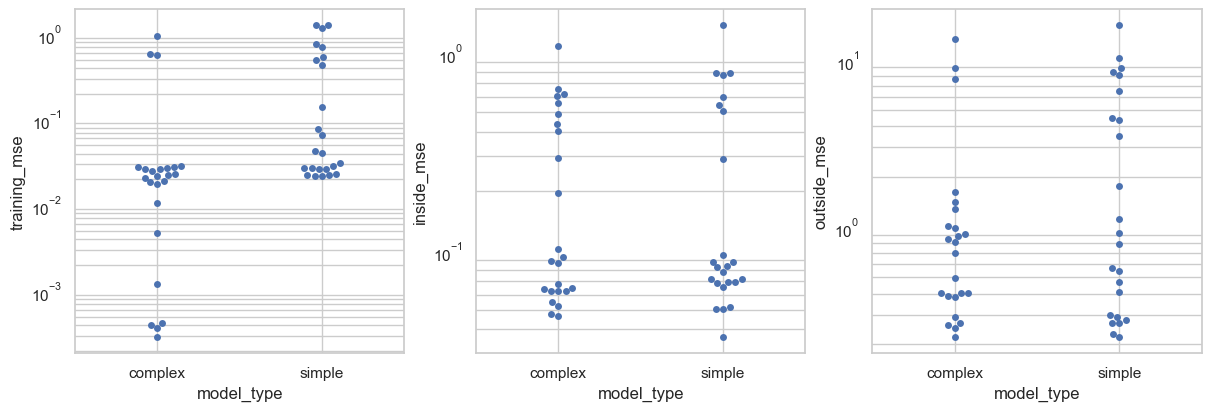

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(
    12, 4), constrained_layout=True, subplot_kw={"yscale": "log"})
show_metrics(METRIC, search_results_df, axes, color_by=None)


We see that, while complex models provide generally better fits in training, their performance are on par (or, in some cases, worse) in both validations.

The same plot will now be shown various times coloring the points depending on parameters values:

- optimizer

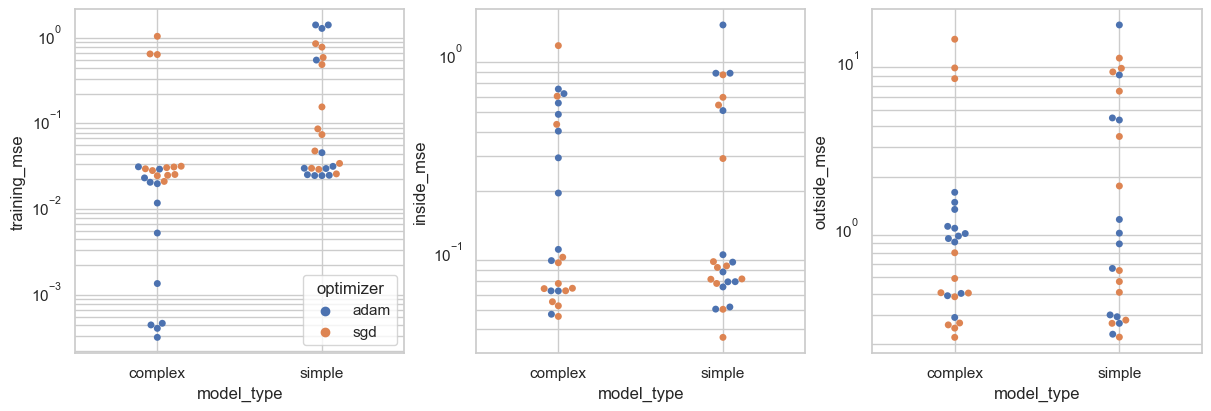

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(
    12, 4), constrained_layout=True, subplot_kw={"yscale": "log"})
show_metrics(METRIC, search_results_df, axes, color_by="optimizer")


While "adam" trains complex models significantly better, it also makes them perform worse in validation: this is probably due to overfitting. For simple models it depends: there is a clear distinction between two groups of models.

Outside validation displays the same tendency for complex models, while simple models show mixed behaviours.

- loss function

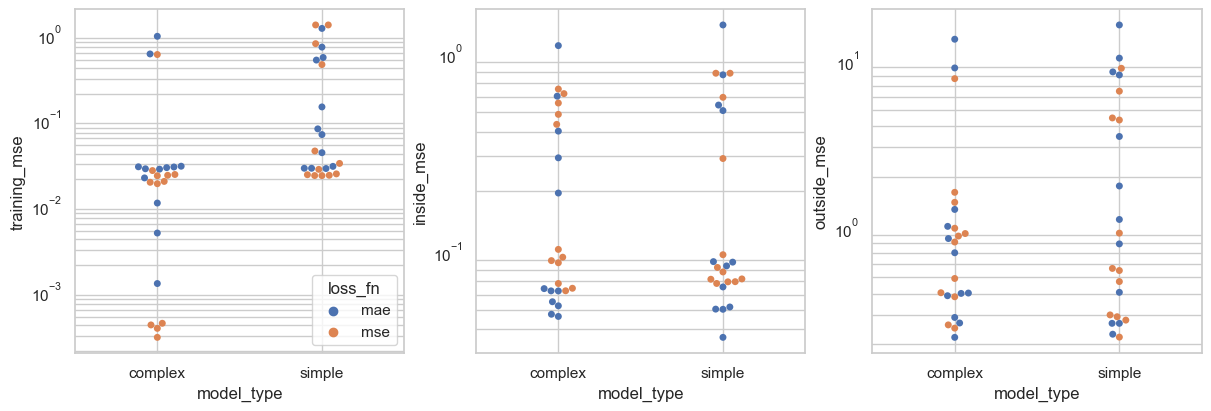

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(
    12, 4), constrained_layout=True, subplot_kw={"yscale": "log"})
show_metrics(METRIC, search_results_df, axes, color_by="loss_fn")


As could be suspected, using the metric as loss generally leads to lower training outcomes. This is not true for simple models: they behave quite erratically.

In inside validation instead we see again that the least the models overfit, the better they perform: models trained with "mae" have generally lower scores, when considering the better scoring models.

In outside validation there is no clear tendency.

- activation function

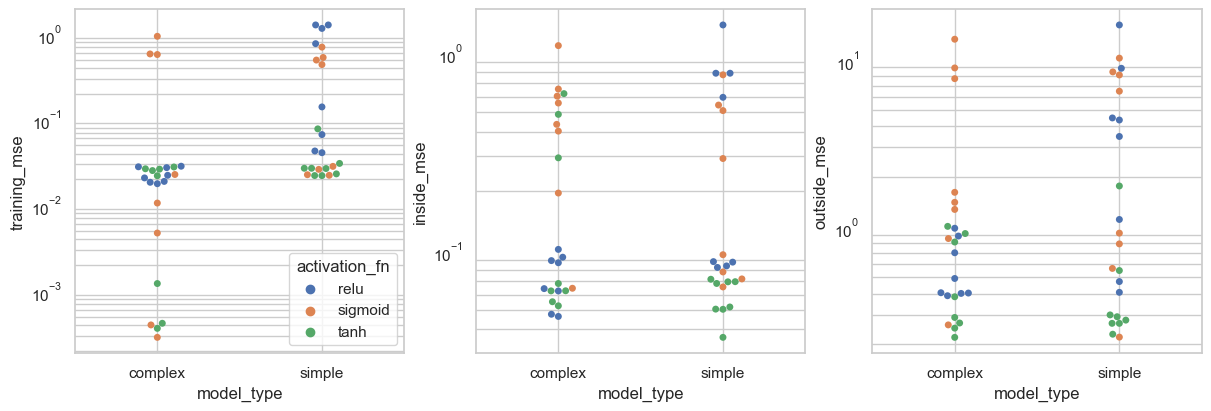

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(
    12, 4), constrained_layout=True, subplot_kw={"yscale": "log"})
show_metrics(METRIC, search_results_df, axes, color_by="activation_fn")


The tendencies we see are:
- "tanh" works generally better than the others, both in training and validation: this is probably due to the shape of the target funcion;
- "ReLU" tends to work poorly with the simple model and well with the complex model (at least in validation);
- "sigmoid" behaves erratically in training ang generally worse than the others in validation.

- learning rate

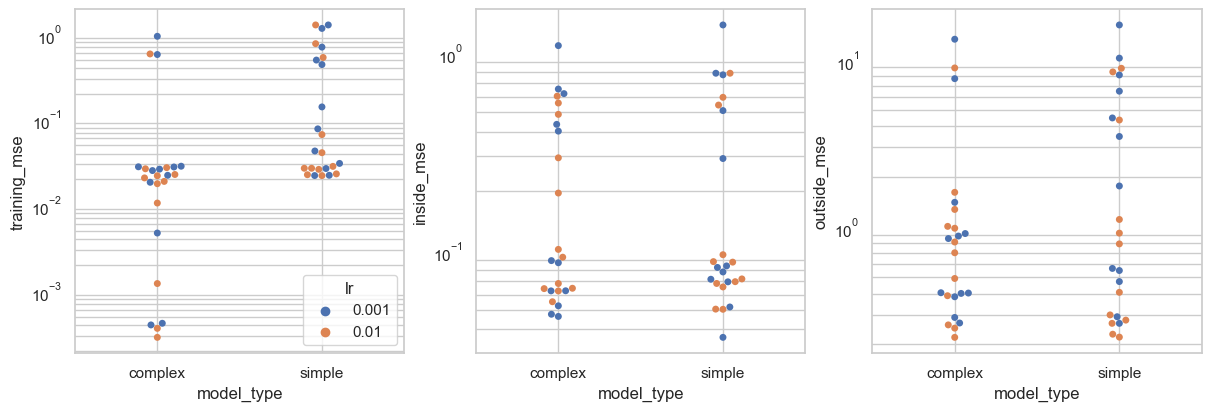

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(
    12, 4), constrained_layout=True, subplot_kw={"yscale": "log"})
show_metrics(METRIC, search_results_df, axes, color_by="lr")


The chosen learning rates do not seem to influence the outcomes significantly

This is now the results table, sorted by the training metric:

In [16]:
search_results_df.sort_values(f"training_{METRIC}", ascending=True)


,model_type,outside_mse,run_number,lr,optimizer,activation_fn,loss_fn,n_layers,n_units,loss,val_loss,training_mse,inside_mse
39,complex,1.611374,39,0.01,adam,sigmoid,mse,2,32,0.000286,0.557476,0.000286,0.557476
41,complex,0.813181,41,0.01,adam,tanh,mse,2,32,0.000365,0.488596,0.000365,0.488596
27,complex,1.404157,27,0.001,adam,sigmoid,mse,2,32,0.000400,0.656029,0.000400,0.656029
29,complex,0.913965,29,0.001,adam,tanh,mse,2,32,0.000418,0.621954,0.000418,0.621954
40,complex,1.008738,40,0.01,adam,tanh,mae,2,32,0.023110,0.369965,0.001216,0.294644
26,complex,0.853168,26,0.001,adam,sigmoid,mae,2,32,0.032685,0.423324,0.004728,0.402012
38,complex,1.273236,38,0.01,adam,sigmoid,mae,2,32,0.043246,0.298190,0.010585,0.195588
37,complex,0.983157,37,0.01,adam,relu,mse,2,32,0.017796,0.101504,0.017796,0.101504
25,complex,0.882937,25,0.001,adam,relu,mse,2,32,0.018499,0.089088,0.018499,0.089088
43,complex,0.492471,43,0.01,sgd,relu,mse,2,32,0.018935,0.092694,0.018935,0.092694


Some models will now be selected to visually check their behaviours

In [21]:
# Generating the plotting helpers
xs = np.linspace(-1.5, 1.5, 500)
plot_panels = make_panels_plotter(xs, models, training_dataset, test_datasets, target=POLY)


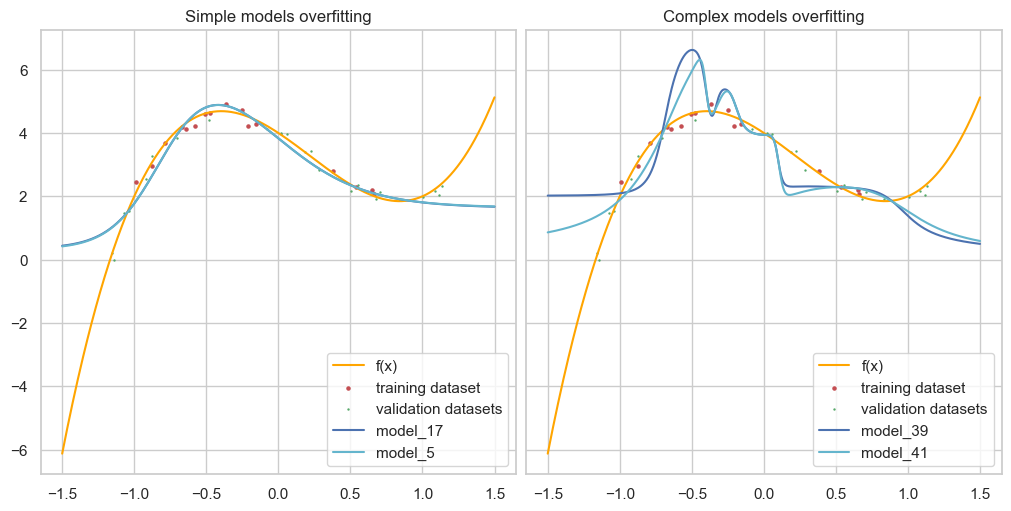

In [22]:
_ = plot_panels(([17, 5], [39, 41]), "overfitting")

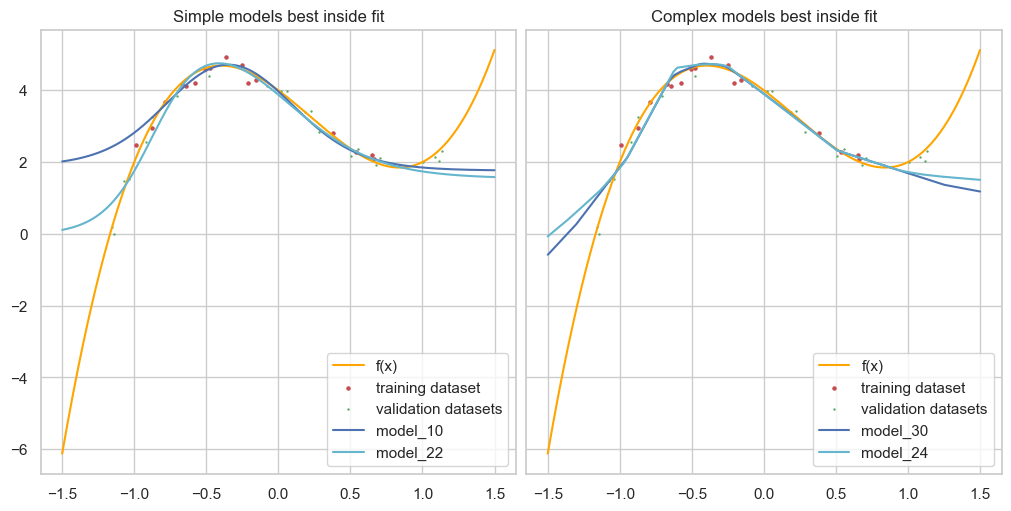

In [23]:
_ = plot_panels(([10, 22], [30, 24]), "best inside fit")


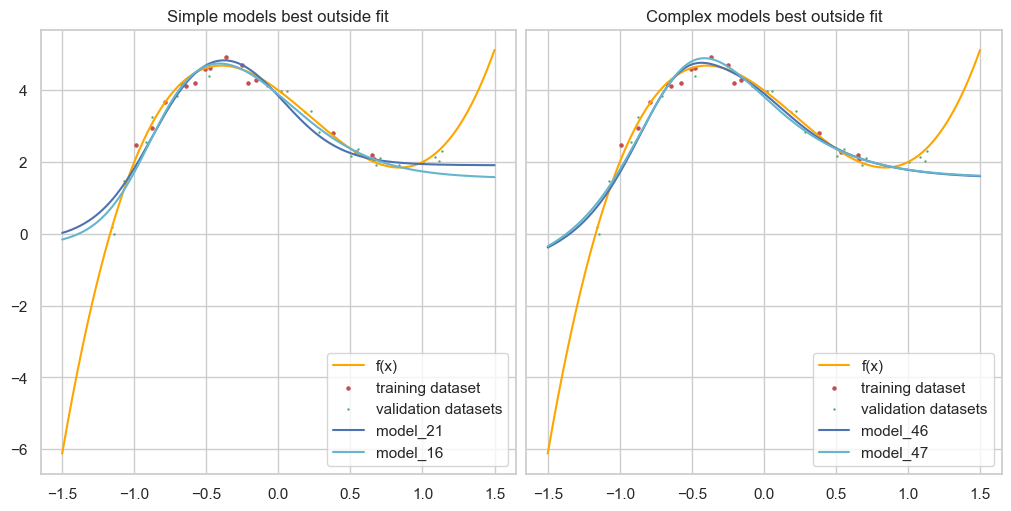

In [24]:
_ = plot_panels(([21, 16], [46, 47]), "best outside fit")

In conclusion we see that various issues has to be considered while training a neural network:
- the model complexity and the optimizer algorithm choice allow for better fits to the data but not necessarily lead to better generalization (overfitting);
- each activation function may better suit a problem or another depending on the target to fit; 
- the condition to stop training has to be chosen carefully, as it makes the difference between over/underfitting and properly training a model. Tensorflow utilities such as `EarlyStopping` and Tensorboard may help on this front.